In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [3]:
video_path = "data/GoPro Video/GX010100_sample.MP4"

In [4]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="TCHW")

/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [5]:
frames.shape

torch.Size([266, 3, 1080, 1920])

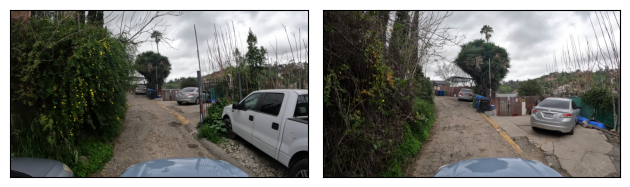

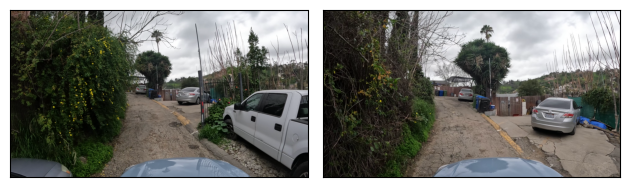

In [6]:
img1_batch = torch.stack([frames[100], frames[200]])
img2_batch = torch.stack([frames[101], frames[201]])

plot(img1_batch)
plot(img2_batch)

In [7]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[1080, 1920], antialias=False)
    img2_batch = F.resize(img2_batch, size=[1080, 1920], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 1080, 1920]), dtype = torch.float32


In [8]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()


In [9]:

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

: 

: 

In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -29.31157875061035, max = 12.207662582397461


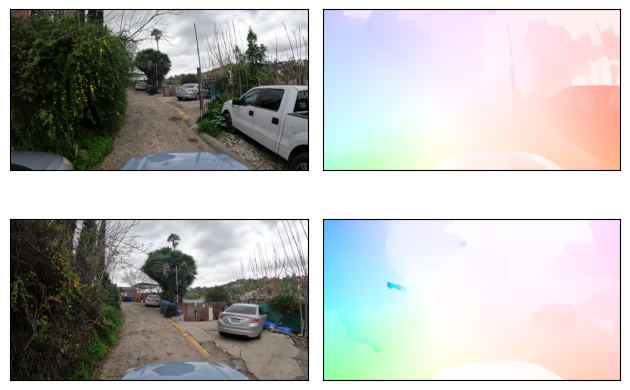

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [ ]:
from torchvision.io import write_jpeg
for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1, img2 = preprocess(img1, img2)

    list_of_flows = model(img1.to(device), img2.to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    output_folder = "/Users/junwonchoi/Desktop/SRILab/parked_cars_road_classification"  # Update this to the folder of your choice
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

ValueError: not enough values to unpack (expected 4, got 3)